To quickly look at the dataset

In [ ]:
from pathlib import Path
from collections import Counter, defaultdict
import random
import numpy as np
from PIL import Image
import pandas as pd

import matplotlib.pyplot as plt
import torchvision.transforms as T
import torchvision.transforms.functional as F

In [29]:
PROJECT_ROOT = Path.cwd().parent  

# for RGB dataset
# DATASET_ROOT = PROJECT_ROOT / "datasets" / "HAGRID" / "hagrid_0_1_classification"

# for GRAY dataset
DATASET_ROOT = PROJECT_ROOT / "datasets" / "HAGRID" / "hagrid_0_1_classification_gray"

SPLITS = ["train", "val", "test"]
print("Dataset root:", DATASET_ROOT)

Dataset root: /Users/lukas.amiet/Documents/CODE/MLonMCU_proj/datasets/HAGRID/hagrid_0_1_classification_gray


In [31]:
# helper functions
IMAGE_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".webp", ".tif", ".tiff"}

def list_images(folder: Path):
    return [p for p in folder.rglob("*") if p.is_file() and p.suffix.lower() in IMAGE_EXTS]

def get_classes(split_dir: Path):
    # assumes structure split/class_name/images...
    return sorted([p.name for p in split_dir.iterdir() if p.is_dir()])

def safe_read_size(path: Path):
    # returns (w, h) or None if unreadable
    try:
        with Image.open(path) as im:
            return im.size  # (w, h)
    except Exception:
        return None

In [32]:
# counts per split + per class
rows = []
for split in SPLITS:
    split_dir = DATASET_ROOT / split
    if not split_dir.exists():
        continue

    classes = get_classes(split_dir)
    split_total = 0

    for cls in classes:
        cls_dir = split_dir / cls
        imgs = list_images(cls_dir)
        n = len(imgs)
        split_total += n
        rows.append({"split": split, "class": cls, "n_images": n})

    rows.append({"split": split, "class": "__TOTAL__", "n_images": split_total})

df_counts = pd.DataFrame(rows)
df_counts

,split,class,n_images
0,train,fist,2354
1,train,one,2349
2,train,others,2353
3,train,palm,2354
4,train,pinkie,2354
5,train,rock,2353
6,train,__TOTAL__,14117
7,val,fist,300
8,val,one,300
9,val,others,300


In [33]:
# pivot view
df_pivot = df_counts[df_counts["class"] != "__TOTAL__"].pivot_table(
    index="class", columns="split", values="n_images", aggfunc="sum", fill_value=0
)
df_pivot.loc["__TOTAL__"] = df_pivot.sum(axis=0)
df_pivot

split,test,train,val
class,,,
fist,500,2354,300
one,500,2349,300
others,500,2353,300
palm,500,2354,300
pinkie,500,2354,300
rock,500,2353,300
__TOTAL__,3000,14117,1800


In [34]:
# scan image resolutions (sizes) for each split

# dataset is huge, set MAX_PER_SPLIT
MAX_PER_SPLIT = 5000 

size_rows = []
failed_rows = []

for split in SPLITS:
    split_dir = DATASET_ROOT / split
    if not split_dir.exists():
        continue

    imgs = list_images(split_dir)
    if MAX_PER_SPLIT is not None and len(imgs) > MAX_PER_SPLIT:
        imgs = random.sample(imgs, MAX_PER_SPLIT)

    for p in imgs:
        sz = safe_read_size(p)
        if sz is None:
            failed_rows.append({"split": split, "path": str(p)})
            continue
        w, h = sz
        size_rows.append({"split": split, "w": w, "h": h, "pixels": w*h, "path": str(p)})

df_sizes = pd.DataFrame(size_rows)
df_failed = pd.DataFrame(failed_rows)

print("Read sizes:", len(df_sizes), "Failed:", len(df_failed))
df_sizes.head()

Read sizes: 9800 Failed: 0


,split,w,h,pixels,path
0,train,512,683,349696,/Users/lukas.amiet/Documents/CODE/MLonMCU_proj...
1,train,512,686,351232,/Users/lukas.amiet/Documents/CODE/MLonMCU_proj...
2,train,683,512,349696,/Users/lukas.amiet/Documents/CODE/MLonMCU_proj...
3,train,512,683,349696,/Users/lukas.amiet/Documents/CODE/MLonMCU_proj...
4,train,512,1138,582656,/Users/lukas.amiet/Documents/CODE/MLonMCU_proj...


In [36]:
# stats per split (min/median/max)
def stats(series):
    return pd.Series({
        "min": int(series.min()),
        "p25": int(series.quantile(0.25)),
        "median": int(series.median()),
        "p75": int(series.quantile(0.75)),
        "max": int(series.max()),
        "mean": float(series.mean())
    })

stats_table = df_sizes.groupby("split").apply(
    lambda g: pd.concat({
        "width": stats(g["w"]),
        "height": stats(g["h"]),
        "pixels": stats(g["pixels"]),
    })
)

stats_table

width                                          height                \
         min    p25 median    p75     max        mean    min    p25 median   
split                                                                        
test   512.0  512.0  512.0  512.0  1138.0  556.351667  512.0  683.0  683.0   
train  512.0  512.0  512.0  512.0  1136.0  550.564800  512.0  683.0  683.0   
val    512.0  512.0  512.0  512.0  1136.0  567.892222  512.0  682.0  683.0   

                                    pixels                                \
         p75     max        mean       min       p25    median       p75   
split                                                                      
test   683.0  1168.0  674.266667  262144.0  349696.0  349696.0  349696.0   
train  683.0  1251.0  680.782200  262144.0  349696.0  349696.0  349696.0   
val    683.0  1168.0  669.643333  262144.0  349696.0  349696.0  350208.0   

                                
            max           mean  
split                           
test   598016.0  367932.586667  
train  640512.0  368305.664000  
val    598016.0  371474.204444

In [37]:
# most common resolutions per split (top 15)
topk = 15
for split, g in df_sizes.groupby("split"):
    ctr = Counter(list(zip(g["w"], g["h"])))
    common = ctr.most_common(topk)
    df_common = pd.DataFrame(common, columns=["(w,h)", "count"])
    print(f"\n=== {split}: top {topk} resolutions ===")
    display(df_common)


=== test: top 15 resolutions ===


,"(w,h)",count
0,"(512, 683)",1855
1,"(683, 512)",283
2,"(910, 512)",161
3,"(512, 684)",120
4,"(512, 910)",104
5,"(512, 512)",69
6,"(512, 686)",67
7,"(512, 690)",44
8,"(512, 682)",39
9,"(512, 681)",26



=== train: top 15 resolutions ===


,"(w,h)",count
0,"(512, 683)",3063
1,"(683, 512)",411
2,"(910, 512)",205
3,"(512, 910)",199
4,"(512, 684)",191
5,"(512, 686)",159
6,"(512, 682)",129
7,"(512, 690)",88
8,"(512, 512)",77
9,"(512, 681)",40



=== val: top 15 resolutions ===


,"(w,h)",count
0,"(512, 683)",1026
1,"(683, 512)",204
2,"(910, 512)",106
3,"(512, 684)",71
4,"(512, 910)",55
5,"(512, 686)",52
6,"(512, 512)",40
7,"(512, 682)",35
8,"(512, 690)",33
9,"(512, 1107)",23


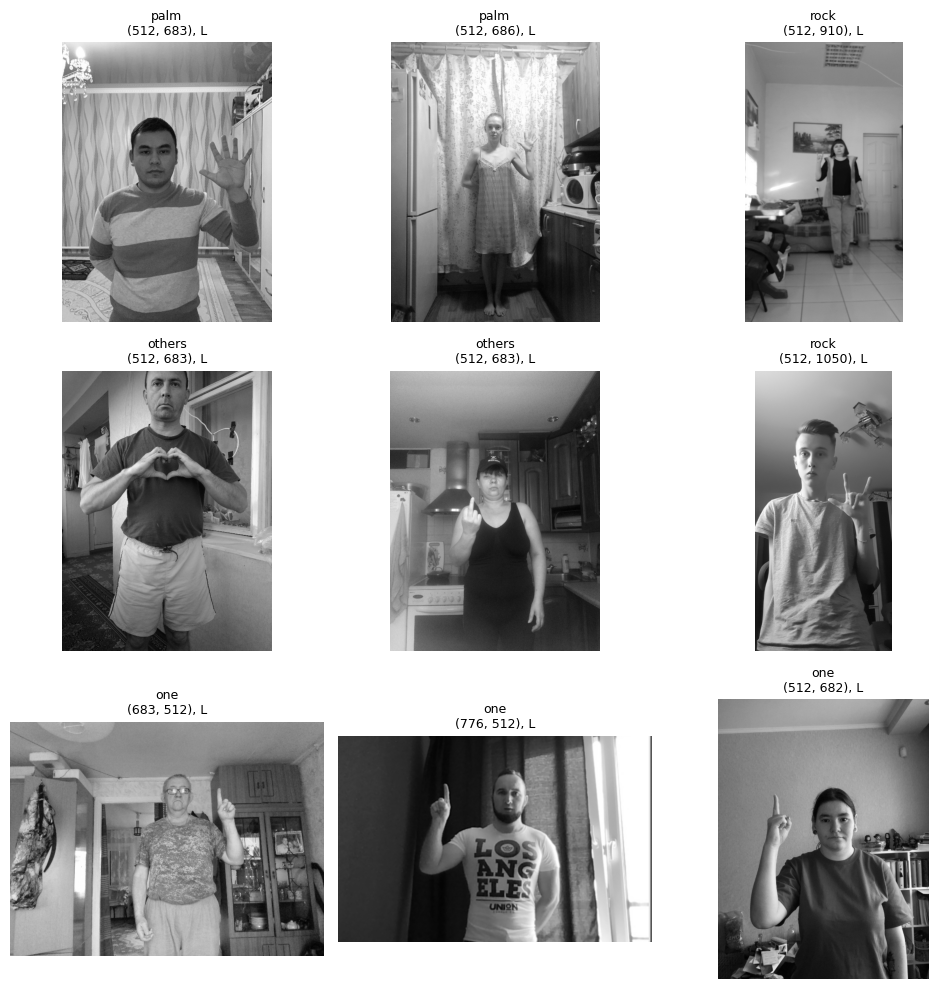

In [38]:
# show a few random images + their sizes
import matplotlib.pyplot as plt

N_SHOW = 9
split = "train"
candidates = list_images(DATASET_ROOT / split)
sample = random.sample(candidates, min(N_SHOW, len(candidates)))

plt.figure(figsize=(10, 10))
for i, p in enumerate(sample, 1):
    with Image.open(p) as im:
        plt.subplot(3, 3, i)
        plt.imshow(im, cmap="gray" if im.mode == "L" else None)
        plt.title(f"{p.parent.name}\n{im.size}, {im.mode}", fontsize=9)
        plt.axis("off")
plt.tight_layout()
plt.show()

# ISSUE WITH NON-UNIFORM IMAGE SIZES

In [40]:
# --- letterbox ---
class LetterboxSquare:
    def __init__(self, size=128, fill=0):
        self.size = size
        self.fill = fill

    def __call__(self, img: Image.Image):
        w, h = img.size
        s = self.size / max(w, h)
        nw, nh = int(round(w * s)), int(round(h * s))
        img = F.resize(img, (nh, nw), interpolation=F.InterpolationMode.BILINEAR)

        pad_w, pad_h = self.size - nw, self.size - nh
        left = pad_w // 2
        right = pad_w - left
        top = pad_h // 2
        bottom = pad_h - top
        return F.pad(img, (left, top, right, bottom), fill=self.fill)

tf_vis = T.Compose([
    T.Grayscale(num_output_channels=1),  # harmless if already grayscale
    LetterboxSquare(128, fill=0),
])


classes: ['fist', 'one', 'others', 'palm', 'pinkie', 'rock']
num train images: 14117


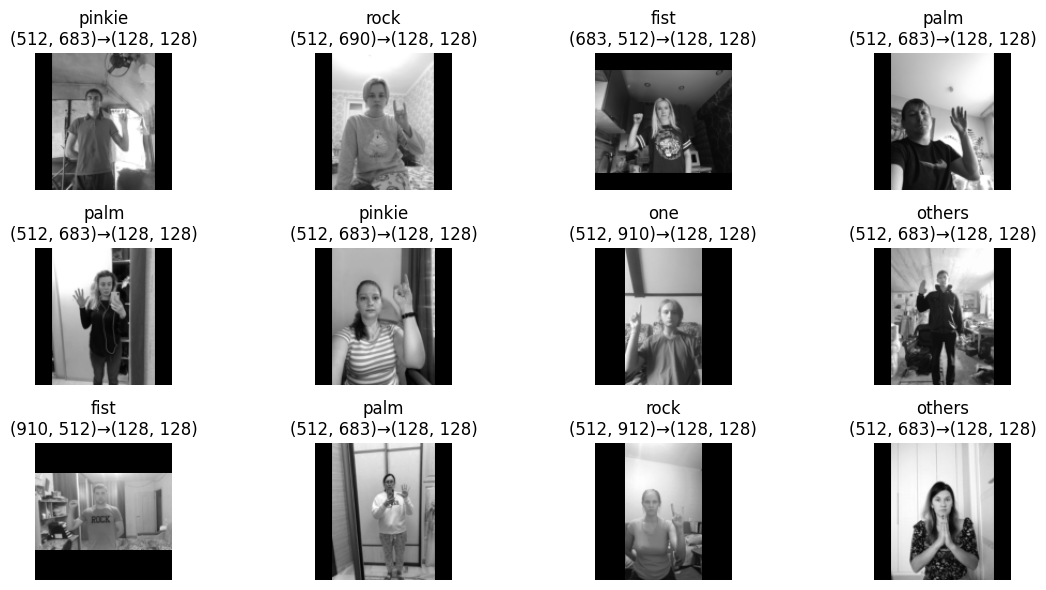

In [41]:
# --- helpers (match your old notebook style) ---
IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}

def get_classes(split_dir: Path):
    return sorted([p.name for p in split_dir.iterdir() if p.is_dir()])

def list_images(cls_dir: Path):
    return sorted([p for p in cls_dir.rglob("*") if p.suffix.lower() in IMG_EXTS])

# --- sample from train ---
train_dir = DATASET_ROOT / "train"
classes = get_classes(train_dir)

# build a pool of (path, class_name)
pool = []
for cls in classes:
    cls_dir = train_dir / cls
    imgs = list_images(cls_dir)
    pool += [(p, cls) for p in imgs]

print("classes:", classes)
print("num train images:", len(pool))

# visualize
N = 12
samples = random.sample(pool, k=min(N, len(pool)))

plt.figure(figsize=(12, 6))
for i, (img_path, cls) in enumerate(samples):
    img = Image.open(img_path)  # grayscale ok
    lb = tf_vis(img)

    ax = plt.subplot(3, 4, i + 1)
    ax.imshow(lb, cmap="gray")
    ax.set_title(f"{cls}\n{img.size}→{lb.size}")
    ax.axis("off")

plt.tight_layout()
plt.show()

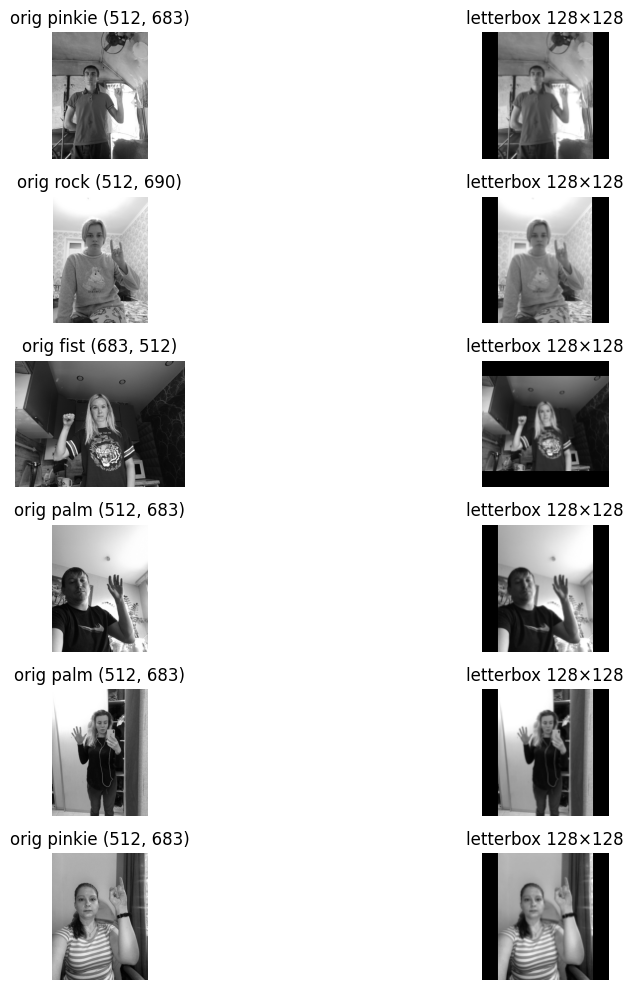

In [42]:
plt.figure(figsize=(12, 10))
for i, (img_path, cls) in enumerate(samples[:6]):
    img = Image.open(img_path)
    lb = tf_vis(img)

    ax1 = plt.subplot(6, 2, 2*i + 1)
    ax1.imshow(img.convert("L"), cmap="gray")
    ax1.set_title(f"orig {cls} {img.size}")
    ax1.axis("off")

    ax2 = plt.subplot(6, 2, 2*i + 2)
    ax2.imshow(lb, cmap="gray")
    ax2.set_title("letterbox 128×128")
    ax2.axis("off")

plt.tight_layout()
plt.show()